<img src="https://digital.hbs.edu/platform-digit/wp-content/uploads/sites/2/2021/03/mercado-libre-logo-2.png" alt="drawing" width="300" />

# [AFFU-2](https://mercadolibre.atlassian.net/browse/AFFU-2) - TFRS Retrieval Recurrente

## 1. Objetivo

En este cuaderno buscamos hacer una segunda iteración sobre la arquitectura utilizada para la tarea Retrieval en el TFRS. La intención es:

- Incluir nuevas features del usuario o los dominios, tomando como referencia las incorporadas en la última versión de la RNN.
- Inspirarnos en las capas usadas en la arquitectura de la RNN que hasta ahora han dado mejor resultado para entender si también funcionan adecuadamente en el sistema de TFRS. Esto tomando como base que en la iteración anterior se hizo una arquitectura básica, siguiendo los ejemplos de TFRS.

## 2. Desarrollo

In [1]:
# imports

!pip install --quiet tensorflow-recommenders
!pip install --quiet --upgrade tensorflow-datasets
!pip install --quiet scann

# INSTALAR PARA GRAFICAR LAS ARQUITECTURAS DE LOS MODELOS
!apt-get -qq install sudo -y
!sudo apt -qq install graphviz -y
!pip install --quiet pydot

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
import os
import pickle
import pandas as pd
from commons.eval_strategies.datasets import Dataset
from commons.eval_strategies.metrics import (cross_selling, mean_average_precision,
                     mean_reciprocal_rank, precision,
                     average_recommendation_popularity,
                     average_percentage_long_tail,
                     prediction_coverage)
from tqdm import tqdm
import dask.dataframe as dd
import uuid
from commons.db import BigQueryConn
#import re

import tensorflow as tf
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.utils.vis_utils import plot_model
pd.set_option('display.max_colwidth', None)

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Dict, Text, List

#from core.models.recurrent_neural_network import RecurrentNeuralNetworkHandler

import numpy as np

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import pprint
import tempfile

import warnings
warnings.filterwarnings("ignore")

from melitk.fda import workspace

from commons.utils.timer import timer
import math
from commons.dates_handler import list_dates_range, date_today
# from replib.descriptors.metaprod2vec import MetaProd2Vec
# from core.settings import MP2VEC_VERSIONS, MP2VEC_SIMILARITY_BY
from dask.dataframe import from_pandas

import json
from sklearn import metrics

# to save in BigQuery
import pathlib
from melitk import melipass
from google.cloud import bigquery
from google.oauth2 import service_account

# styling matplotlib graphs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

In [3]:
# Constants and parameters like SITE_ID, urls, etc

SITE_ID = 'MLA'
db = BigQueryConn()

## 2.1 Carga y preprocesamiento de datos

### Carga de los datos

En este cuaderno cargamos desde la etl `22.01.26-rnn-tfrs-redefine-input`que trae los datos requeridos para el TFRS así como para la nueva arquitectura de la RNN. Por la gran cantidad de datos fue necesario dividir el dataset en 10 subpaquetes, que deberían ser concatenados en uno sólo.

Para mayor eficiencia en la experimentación, solo se obtienen resultados con 1M de usuarios. Para esto, solo se usarán los paquetes 1, 2 y 10, conformando el mismo conjunto de datos usados para experimentación inicial con la RNN. En una fase posterior se podrían concatenar los 20M de usuarios de los 10 paquetes de datos obtenidos con la ETL.

_______
**NOTA**: si es la primera vez que se corre el cuaderno ejecutar las siguientes celdas. Si los datasets con 1M de usuarios para entrenamiento, prueba y validación se tienen ya creados, pasar a la fase llamada **Preprocesamiento**.

In [ ]:
etl_version = '22.01.28-rnn-tfrs-redefine-input'
metadata = workspace.load_etl_file('metadata', version=etl_version)
metadata = pickle.loads(metadata)

In [6]:
metadata['uri_clean_events_tfrs']

['gs://affinity-etl/20220202_230855_b910e246fad9495f99b376acd21872b5',
 'gs://affinity-etl/20220202_231200_653f4912443c450ea32457aba804916c',
 'gs://affinity-etl/20220202_231455_e0684f3ab1694f17896b1a1db5a07a1f',
 'gs://affinity-etl/20220202_231757_1abb093e2c0f4c579226e52f753d5611',
 'gs://affinity-etl/20220202_232055_45bd021da0df41c19de1d4ab312ebced',
 'gs://affinity-etl/20220202_232348_e0f91c65ceef4d8f8b9a84e93cc7c81c',
 'gs://affinity-etl/20220202_232649_2d8e629a9f68422789d12605663d8570',
 'gs://affinity-etl/20220202_232944_02c70d79212244068c190d3834772546',
 'gs://affinity-etl/20220202_233243_9da6bbbbb71f402d8e2257e054c1ac5a',
 'gs://affinity-etl/20220202_233539_35a454e0f4e34cfba17ef150c9235e8d']

Recordar que cada paquetito, corresponde a un rango de usuarios dado por:

In [7]:
destination = ['gs://affinity-etl/20220201_123934_df6826a8d21449b18a17095960df1f94']
ddf_1 = dd.read_parquet(destination, storage_options={"token": db.json_cred})
df_1 = ddf_1.compute()

In [8]:
df_1.shape

(1971430, 8)

In [9]:
destination = ['gs://affinity-etl/20220201_124237_8cf0ea8edc9a4c29a106363442e0bffd']
ddf_2 = dd.read_parquet(destination, storage_options={"token": db.json_cred})
df_2 = ddf_2.compute()

In [10]:
df_2.shape

(1973388, 8)

In [11]:
destination = ['gs://affinity-etl/20220201_130513_2799fc550653458da484d16b8ef30924']
ddf_10 = dd.read_parquet(destination, storage_options={"token": db.json_cred})
df_10 = ddf_10.compute()

In [12]:
df_10.shape

(1970010, 8)

### Separamos datasets para entrenamiento y evaluación

In [17]:
df_union = pd.concat([df_1, df_2], join = 'outer', ignore_index = True)

In [18]:
df_union.shape

(3944818, 8)

#### Dataset de Entrenamiento:

In [19]:
df_training = df_union.loc[(df_union.user_id % 100 >= 6) & (df_union.user_id %100 <= 15)]

In [20]:
df_training.shape

(1972186, 8)

#### Dataset de testing:

In [21]:
df_testing = df_10.loc[(df_10.user_id % 100 >= 96) & (df_10.user_id % 100 <= 99)]

In [22]:
df_testing.shape

(788184, 8)

#### Dataset de validation: por ahora este no lo usamos, para una futura iteración se deja explorar si el método .fit en TFRS permite usarlo en la parametrización del entrenamiento

In [23]:
df_validation = df_1.loc[(df_1.user_id % 100 >= 0) & (df_1.user_id % 100 <= 5)]

In [24]:
df_validation.shape

(1183609, 8)

### Selección de características de interés y guardado de datasets:

En esta iteración solo usaremos `domains_string` y `target_string`:

Entrenamiento:

In [25]:
df_train_sel = df_training[['domains_string', 'target_string']]

In [29]:
tmp = "/alloc/data/fury_fda-mendel/notebooks/20220228-AFFU-2-TFRS/"
path = os.path.join(tmp, "1M_users_training")

In [30]:
df_train_sel.to_pickle(path)

Testing:

In [31]:
df_test_sel = df_testing[['domains_string', 'target_string']]

In [32]:
path = os.path.join(tmp, "1M_users_testing")

In [33]:
df_test_sel.to_pickle(path)

Validación:

In [34]:
df_val_sel = df_validation[['domains_string', 'target_string']]

In [35]:
path = os.path.join(tmp, "1M_users_validation")

In [36]:
df_val_sel.to_pickle(path)

### Preprocesamiento

Convertimos ahora a un diccionario para pasar a un tensor dataset mediante `tensor_slices`:

----------------------------
Nota: Si las celdas anteriores ya se ejecutaron al menos una vez, se tienen ya los datos de entrenamiento, prueba y validación en pickles y por lo tanto, pueden cargarse directamente desde las siguiente líneas para optimizar recursos:

In [37]:
file = open('/alloc/data/fury_fda-mendel/notebooks/20220228-AFFU-2-TFRS/1M_users_training','rb')
df_train_sel = pickle.load(file)

In [38]:
file2 = open('/alloc/data/fury_fda-mendel/notebooks/20220228-AFFU-2-TFRS/1M_users_testing','rb')
df_test_sel = pickle.load(file2)

In [39]:
file3 = open('/alloc/data/fury_fda-mendel/notebooks/20220228-AFFU-2-TFRS/1M_users_validation','rb')
df_val_sel = pickle.load(file3)

________

In [40]:
df_train_sel.head(3)

,domains_string,target_string
0,"[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , MLA-WINES, MLA-MOTORCYCLE_IGNITION_SWITCHES, MLA-FIELD_HOCKEY_STICKS, MLA-SHEET_FOLDING_MACHINES, MLA-GAMEPADS_AND_JOYSTICKS, MLA-WINES, MLA-CELLPHONE_ACCESSORIES, MLA-FOOTBALL_SHOES, MLA-HAIR_CLIPPERS]",MLA-SAFETY_CONES
1,"[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , MLA-MOTORCYCLE_HELMETS, MLA-DATA_CABLES_AND_ADAPTERS, MLA-MOTORCYCLE_HELMETS, MLA-SNEAKERS, MLA-MOTORCYCLE_HELMETS, MLA-SNEAKERS, MLA-CELLPHONE_ACCESSORIES]",MLA-SAFETY_CONES
10,"[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , MLA-PILLOWS, MLA-STARTERS, MLA-STARTERS, MLA-LAPTOP_BATTERIES, MLA-TELEVISIONS, MLA-AUTOMOBILE_DOOR_GLASSES, MLA-RANGES, MLA-HOME_APPLIANCES_ACCESSORIES_AND_SPARE_PARTS, MLA-HOME_APPLIANCES_ACCESSORIES_AND_SPARE_PARTS, MLA-GAS_HEATERS, MLA-AUTOMOBILE_DOOR_GLASSES, MLA-ELECTRIC_HOME_HEATERS, MLA-CHOCOLATES, MLA-COOKING_OILS]",MLA-SAFETY_CONES


In [41]:
df_train_sel['target_string'] = df_train_sel['target_string'].apply(lambda x: x.rsplit())

In [42]:
df_train_sel.head(2)

,domains_string,target_string
0,"[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , MLA-WINES, MLA-MOTORCYCLE_IGNITION_SWITCHES, MLA-FIELD_HOCKEY_STICKS, MLA-SHEET_FOLDING_MACHINES, MLA-GAMEPADS_AND_JOYSTICKS, MLA-WINES, MLA-CELLPHONE_ACCESSORIES, MLA-FOOTBALL_SHOES, MLA-HAIR_CLIPPERS]",[MLA-SAFETY_CONES]
1,"[, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , MLA-MOTORCYCLE_HELMETS, MLA-DATA_CABLES_AND_ADAPTERS, MLA-MOTORCYCLE_HELMETS, MLA-SNEAKERS, MLA-MOTORCYCLE_HELMETS, MLA-SNEAKERS, MLA-CELLPHONE_ACCESSORIES]",[MLA-SAFETY_CONES]


In [43]:
df_test_sel['target_string'] = df_test_sel['target_string'].apply(lambda x: x.rsplit())

In [44]:
df_val_sel['target_string'] = df_val_sel['target_string'].apply(lambda x: x.rsplit())

In [45]:
df_train_dict = df_train_sel.to_dict(orient = 'list')

In [46]:
df_test_dict = df_test_sel.to_dict(orient = 'list')

In [47]:
df_val_dict = df_val_sel.to_dict(orient = 'list')

In [53]:
interactions_train = tf.data.Dataset.from_tensor_slices(df_train_dict)

In [49]:
interactions_test = tf.data.Dataset.from_tensor_slices(df_test_dict)

In [50]:
interactions_val = tf.data.Dataset.from_tensor_slices(df_val_dict)

In [52]:
for x in interactions_train.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'domains_string': array([b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'MLA-WINES', b'MLA-MOTORCYCLE_IGNITION_SWITCHES',
       b'MLA-FIELD_HOCKEY_STICKS', b'MLA-SHEET_FOLDING_MACHINES',
       b'MLA-GAMEPADS_AND_JOYSTICKS', b'MLA-WINES',
       b'MLA-CELLPHONE_ACCESSORIES', b'MLA-FOOTBALL_SHOES',
       b'MLA-HAIR_CLIPPERS'], dtype=object),
 'target_string': array([b'MLA-SAFETY_CONES'], dtype=object)}


In [54]:
interactions_train = interactions_train.map(lambda x: {
                               "domains_string": x["domains_string"],
                               "target_string": x["target_string"]})

In [55]:
interactions_test = interactions_test.map(lambda x: {
                                "domains_string": x["domains_string"],
                                "target_string": x["target_string"]})

In [56]:
interactions_val = interactions_val.map(lambda x: {
                                "domains_string": x["domains_string"],
                                "target_string": x["target_string"]})

### Ahora cargamos la lista de dominios únicos

Por ahora hacemos la carga como en la última iteración que es lanzando la consulta desde este cuaderno:


In [58]:
domain_query = f"""
SELECT distinct domain_id FROM `mld-marketing.clustering.catalog_categories`
WHERE site_id = 'MLA'
"""

domain = db.query(domain_query, output='storage')

In [59]:
ddf_domain = dd.read_parquet(domain, storage_options={"token": db.json_cred})
df_domain = ddf_domain.compute()

In [62]:
tmp = "/alloc/data/fury_fda-mendel/notebooks/20220228-AFFU-2-TFRS/"
path = os.path.join(tmp, "domain")

In [63]:
df_domain.to_pickle(path)

In [64]:
domain_dict = dict(df_domain)

In [65]:
domain_dataset = tf.data.Dataset.from_tensor_slices(domain_dict)

In [66]:
for x in domain_dataset.take(3).as_numpy_iterator():
    pprint.pprint(x)

{'domain_id': b'MLA-CEREALS'}
{'domain_id': b'MLA-DIPS_AND_SPREADS'}
{'domain_id': b'MLA-JUICES'}


In [67]:
domain_dataset = domain_dataset.map(lambda x: x["domain_id"])

### Implementación del modelo

In [68]:
domain_ids = domain_dataset.batch(1_000)

In [69]:
unique_domain_ids = np.unique(np.concatenate(list(domain_ids)))

In [70]:
len(unique_domain_ids)

4800

In [71]:
embedding_dimension = 32

In [72]:
query_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary = unique_domain_ids, max_tokens=len(unique_domain_ids)+1),
    tf.keras.layers.Embedding(len(unique_domain_ids) + 1, embedding_dimension, mask_zero = True),
    tf.keras.layers.LSTM(embedding_dimension)
    #tf.keras.layers.GRU(embedding_dimension)
])

In [73]:
candidate_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary = unique_domain_ids, max_tokens=len(unique_domain_ids)+1),
    tf.keras.layers.Embedding(len(unique_domain_ids) + 1, embedding_dimension)
])

In [74]:
metrics = tfrs.metrics.FactorizedTopK( candidates = domain_dataset.batch(128).map(candidate_model))

task = tfrs.tasks.Retrieval(metrics = metrics)

In [75]:
class Model(tfrs.Model):
    
    def __init__(self, query_model: tf.keras.Model, candidate_model: tf.keras.Model, task: tfrs.tasks.Retrieval):
        super().__init__()
        
        self.query_model = query_model
        self.candidate_model = candidate_model
        self.task = task
        
    def compute_loss(self, features, training = True):
        watch_history = features["domains_string"]
        watch_next_label = features["target_string"]
        
        query_embedding = self.query_model(watch_history)
        candidate_embedding = self.candidate_model(watch_next_label)
        
        return self.task(query_embedding, candidate_embedding)

### Entrenando y evaluando el modelo

In [76]:
model = Model(query_model, candidate_model, task)

In [77]:
model.compile(optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1), metrics = ['accuracy'])

In [78]:
cached_train = interactions_train.shuffle(10_000).batch(12800).cache()
cached_test = interactions_test.batch(2560).cache()

In [79]:
%%time
history = model.fit(cached_train, epochs = 3)

Epoch 1/3
155/155 [==============================] - 263s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0042 - factorized_top_k/top_5_categorical_accuracy: 0.0169 - factorized_top_k/top_10_categorical_accuracy: 0.0265 - factorized_top_k/top_50_categorical_accuracy: 0.0822 - factorized_top_k/top_100_categorical_accuracy: 0.1361 - loss: 117080.7116 - regularization_loss: 0.0000e+00 - total_loss: 117080.7116
Epoch 2/3
155/155 [==============================] - 223s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0035 - factorized_top_k/top_5_categorical_accuracy: 0.0176 - factorized_top_k/top_10_categorical_accuracy: 0.0327 - factorized_top_k/top_50_categorical_accuracy: 0.1163 - factorized_top_k/top_100_categorical_accuracy: 0.1898 - loss: 114266.9957 - regularization_loss: 0.0000e+00 - total_loss: 114266.9957
Epoch 3/3
155/155 [==============================] - 232s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0046 - factorized_top_k/top_5_categorical_acc

In [80]:
history.history['total_loss']

[6634.3447265625, 6585.57275390625, 6529.7373046875]

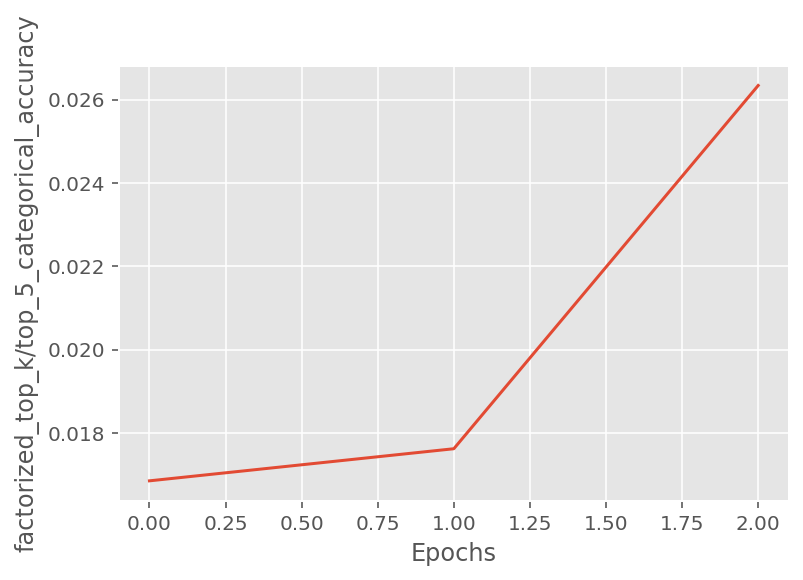

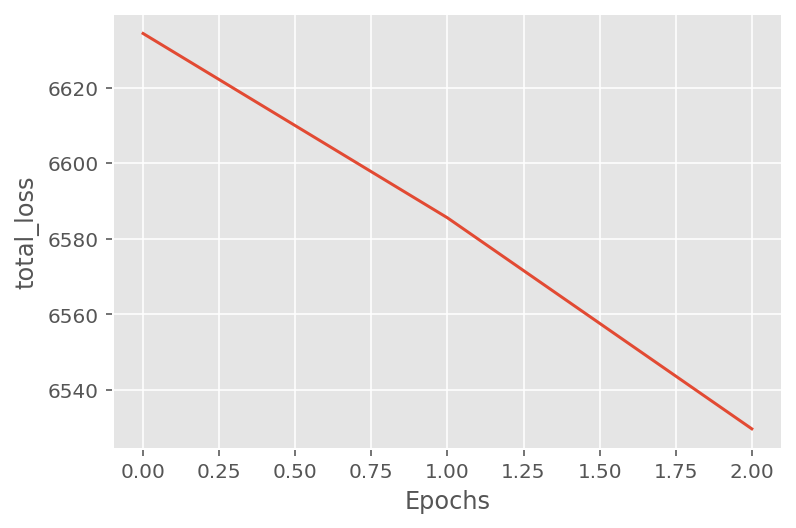

In [81]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    #plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    #plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history, 'factorized_top_k/top_5_categorical_accuracy')
plot_graphs(history, 'total_loss')

In [82]:
%%time
model.evaluate(cached_test, return_dict = True)

308/308 [==============================] - 100s 303ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0071 - factorized_top_k/top_5_categorical_accuracy: 0.0349 - factorized_top_k/top_10_categorical_accuracy: 0.0591 - factorized_top_k/top_50_categorical_accuracy: 0.1641 - factorized_top_k/top_100_categorical_accuracy: 0.2394 - loss: 19210.2987 - regularization_loss: 0.0000e+00 - total_loss: 19210.2987
CPU times: user 19min 25s, sys: 2min 11s, total: 21min 36s
Wall time: 1min 40s


{'factorized_top_k/top_1_categorical_accuracy': 0.007071952801197767,
 'factorized_top_k/top_5_categorical_accuracy': 0.034948691725730896,
 'factorized_top_k/top_10_categorical_accuracy': 0.05910802632570267,
 'factorized_top_k/top_50_categorical_accuracy': 0.1641431450843811,
 'factorized_top_k/top_100_categorical_accuracy': 0.23944027721881866,
 'loss': 17489.142578125,
 'regularization_loss': 0,
 'total_loss': 17489.142578125}

**Nota**: ejecutar la siguiente celda si el directorio no existe. Si es una nueva arquitectura que se desea probar (con capa GRU o diferente número de embeddings) modificar el nombre del directory y crear un nuevo directorio.

In [ ]:
parent = '/alloc/data/fury_fda-mendel/training/'
directory = 'TFRS_20220221_LSTM'
path = os.path.join(parent,directory)
os.mkdir(path)

In [ ]:
parent = '/alloc/data/fury_fda-mendel/training/TFRS_20220221_LSTM'
directory = 'model_images'
path = os.path.join(parent,directory)
os.mkdir(path)

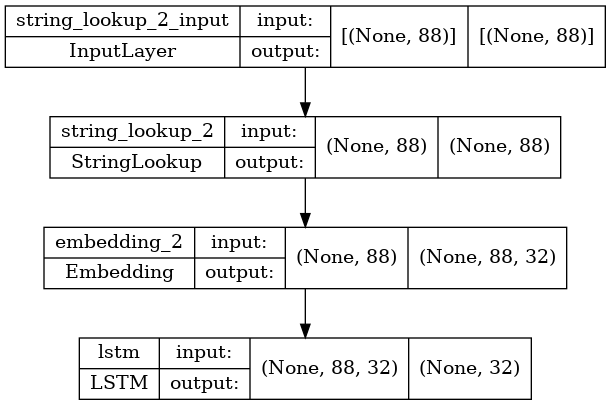

In [154]:
# Graficar el modelo de los usuarios
tf.keras.utils.plot_model(query_model, '/alloc/data/fury_fda-mendel/training/TFRS_20220221_LSTM/model_images/query_model.png', show_shapes=True)

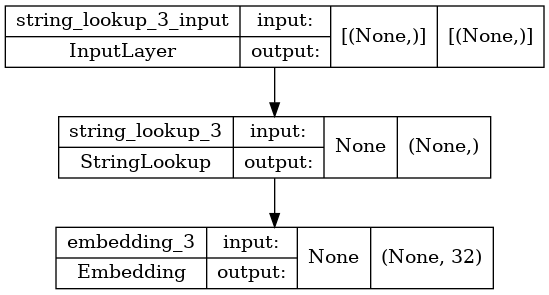

In [155]:
# Graficar el modelo de los dominios
tf.keras.utils.plot_model(candidate_model, '/alloc/data/fury_fda-mendel/training/TFRS_20220221_LSTM/model_images/candidate_model.png', show_shapes=True)

### Predicciones

Con el algoritmo de fuerza bruta:

In [84]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model, k=50)

In [85]:
index.index_from_dataset(
    domain_dataset.batch(100).map(lambda domain_id: (domain_id, model.candidate_model(domain_id))))

Crear nuevo directorio si no existe:

In [86]:
tmp = "/alloc/data/fury_fda-mendel/training/"
path = os.path.join(tmp, "TFRS_20220221_LSTM")

In [ ]:
tf.saved_model.save(index, path)

Hacemos primero un sanity check:

In [88]:
for x in interactions_val.take(1).as_numpy_iterator():
    pprint.pprint(x)
    domain_sanity_check = x

{'domains_string': array([b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'MLA-AUTOMOTIVE_WATER_PUMPS',
       b'MLA-VEHICLE_BRAKE_PADS', b'MLA-CATS_AND_DOGS_FOODS',
       b'MLA-AUTOMOTIVE_FRONT_BUMPERS', b'MLA-CAR_HOODS',
       b'MLA-VEHICLE_ACCESSORIES', b'MLA-COMMERCIAL_NO_LIGHT_SIGNS',
       b'MLA-ARTIFICIAL_PLANTS', b'MLA-SHIRTS', b'MLA-PANTS',
       b'MLA-CLOTHING_LOTS', b'MLA-CLOTHING',
       b'MLA-AUTOMOTIVE_TRANSMISSION_GEARS',
       b'MLA-AUTOMOTIVE_CLUTCH_KITS', b'MLA-SHOCK_MOUNT_INSOLATORS',
       b'MLA-AUTOMOTIVE_CLUTCH_KITS', b'MLA-SHOCK_MOUNT_INSOLATORS',
       b'MLA-AUTOMOTIVE_TRANSMISSION_GEARS',
       b'MLA-AUTOMOTIVE_TRANSMISSION_G

In [89]:
domain_sanity_check = domain_sanity_check['domains_string']

In [91]:
domain_sanity_check.shape

(88,)

In [92]:
domain_sanity_check = np.reshape(domain_sanity_check,(1,len(domain_sanity_check),))

In [93]:
domain_sanity_check.shape

(1, 88)

In [94]:
scores, domains_rec = index(domain_sanity_check)

In [95]:
domains_rec

<tf.Tensor: shape=(1, 50), dtype=string, numpy=
array([[b'MLA-DIFFERENTIALS', b'MLA-ENGINE_VALVES_SPRING_RETAINERS',
        b'MLA-AUTOMOTIVE_SHOCK_ABSORBER_KITS', b'MLA-INJECTION_PUMPS',
        b'MLA-SUSPENSION_BALL_JOINTS', b'MLA-DRIVE_SHAFTS',
        b'MLA-AUTOMOTIVE_TRANSMISSION_GEARS',
        b'MLA-VEHICLE_CYLINDER_LINERS', b'MLA-ENGINE_BEARINGS',
        b'MLA-AUTOMOTIVE_TRIPOD_JOINT_SPIDERS', b'MLA-ENGINE_BLOCKS',
        b'MLA-CLUTCH_BEARINGS',
        b'MLA-AUTOMOTIVE_FUEL_PRESSURE_REGULATORS',
        b'MLA-BRAKE_BOOSTERS', b'MLA-AUTOMOTIVE_SHOCK_ABSORBERS',
        b'MLA-DISTRIBUTION_KITS', b'MLA-ELECTRIC_TIRE_CHANGERS',
        b'MLA-VEHICLE_ENGINE_PISTON_RING_SETS',
        b'MLA-ENGINE_CYLINDER_HEAD_BOLTS',
        b'MLA-AUTOMOTIVE_ENGINE_TIMING_COVERS',
        b'MLA-AUTOMOTIVE_SUSPENSION_CONTROL_ARMS',
        b'MLA-ENGINE_GASKET_SETS', b'MLA-AUTOMOTIVE_CLUTCH_DISCS',
        b'MLA-AUTOMOTIVE_OIL_PUMPS', b'MLA-EXHAUST_MANIFOLDS',
        b'MLA-AUTOMOTIVE_ENGINE_ROCKE

In [96]:
scores

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[2.9514248, 2.9060664, 2.8771071, 2.854928 , 2.8071833, 2.8064976,
        2.8027508, 2.782631 , 2.7761564, 2.770103 , 2.7612534, 2.7393613,
        2.7315269, 2.7254171, 2.72019  , 2.714986 , 2.712822 , 2.689744 ,
        2.6853673, 2.6819382, 2.6744862, 2.6606774, 2.6602688, 2.6536775,
        2.6531546, 2.6531157, 2.649438 , 2.6460743, 2.6425285, 2.6344566,
        2.630796 , 2.6293774, 2.6263785, 2.6262062, 2.619824 , 2.6187143,
        2.6155353, 2.615467 , 2.6144264, 2.6120918, 2.6108904, 2.5913594,
        2.5873208, 2.585763 , 2.5746655, 2.5718126, 2.565822 , 2.5583134,
        2.552162 , 2.551681 ]], dtype=float32)>

Ahora con Scann:

In [97]:
scann = tfrs.layers.factorized_top_k.ScaNN(model.query_model, k=50)

In [ ]:
scann.index_from_dataset(
    domain_dataset.batch(100).map(lambda domain_id: (domain_id, model.candidate_model(domain_id))))

Crear nuevo directorio si no existe:

In [100]:
tmp = "/alloc/data/fury_fda-mendel/training/"
path = os.path.join(tmp, "TFRS_20220221_LSTM_Scann")

In [ ]:
tf.saved_model.save(scann, path)

In [102]:
scores_scann, domains_rec_scann = scann(domain_sanity_check)

In [103]:
domains_rec_scann

<tf.Tensor: shape=(1, 50), dtype=string, numpy=
array([[b'MLA-AUTOMOTIVE_SHOCK_ABSORBER_KITS',
        b'MLA-ENGINE_VALVES_SPRING_RETAINERS', b'MLA-DIFFERENTIALS',
        b'MLA-AUTOMOTIVE_TRIPOD_JOINT_SPIDERS',
        b'MLA-SUSPENSION_BALL_JOINTS', b'MLA-AUTOMOTIVE_SHOCK_ABSORBERS',
        b'MLA-EXHAUST_MANIFOLDS', b'MLA-VEHICLE_ENGINE_PISTON_RING_SETS',
        b'MLA-ENGINE_COOLING_FAN_CLUTCHES',
        b'MLA-AUTOMOTIVE_CLUTCH_DISCS', b'MLA-AUTOMOTIVE_OIL_PUMPS',
        b'MLA-INJECTION_PUMPS', b'MLA-CLUTCH_BEARINGS',
        b'MLA-AUTOMOTIVE_ENGINE_TIMING_COVERS', b'MLA-ENGINE_BLOCKS',
        b'MLA-AUTOMOTIVE_SUSPENSION_CONTROL_ARMS', b'MLA-CRANKSHAFTS',
        b'MLA-VEHICLE_CV_AXLES', b'MLA-BRAKE_BOOSTERS',
        b'MLA-AUTOMOTIVE_ENGINE_ROCKER_ARMS', b'MLA-DRIVE_SHAFTS',
        b'MLA-AUTOMOTIVE_ENGINE_VALVE_COVERS', b'MLA-HOOD_HINGES',
        b'MLA-AUTOMOTIVE_TIMING_BELT_TENSIONER_PULLEYS',
        b'MLA-VEHICLE_CYLINDER_LINERS',
        b'MLA-AUTOMOTIVE_FUEL_PRESSURE_REGU

In [88]:
scores_scann

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[3.1362052, 3.0989707, 3.089662 , 2.973304 , 2.9639955, 2.9500325,
        2.940724 , 2.9314156, 2.912798 , 2.8709095, 2.8616004, 2.8616004,
        2.8429832, 2.8383288, 2.8290205, 2.824366 , 2.824366 , 2.8197117,
        2.8150575, 2.8150573, 2.7731688, 2.76386  , 2.76386  , 2.7638597,
        2.7638597, 2.749897 , 2.749897 , 2.749897 , 2.7405882, 2.735934 ,
        2.7266254, 2.7219713, 2.721971 , 2.721971 , 2.7033536, 2.7033536,
        2.6847365, 2.680082 , 2.675428 , 2.675428 , 2.675428 , 2.6661193,
        2.666119 , 2.661465 , 2.661465 , 2.6568108, 2.647502 , 2.6381934,
        2.6381934, 2.6335392]], dtype=float32)>

## 3. Conclusion

Se logró hacer la implementación de TFRS utilizando como features la secuencia de hasta los últimos 88 dominios visitados para estimar el próximo dominio a ser visitado. Para esto se usaron dos arquitecturas, una con capa LSTM y la otra con capa GRU. 

Para una mejor experimentación y obtención de resultados más confiables, se concluye que los siguientes pasos son:

- migrar el cuaderno a un lab GPU, con el fin de poder ejecutar entrenamientos con mayor número de épocas para observar su desempeño y poder comparar entre modelos y arquitecturas.
- enlazar con métricas offline con el objetivo de evaluar de manera más integra.
- convertir la carga de datos a formato TFRecords para lograr la ejecución del entrenamiento en el lab con gpu.